In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm
from utils import RESULTS_ROOT

ORDERED_FOLDERS_EC = [
    "20210916_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211018_FTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211019_AAFTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    "20211119_FTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20210917_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_FTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_AAFTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211121_AAFTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211121_IAAFTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20210917_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_FTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_AAFTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211025_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_FTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_AAFTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_IAAFTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
]

ORDERED_FOLDERS_EO = [
    "20211108_4microstates_2.0-20.0Hz_EO_subjectwise",
    # "20211109_FTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    # "20211109_AAFTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    # "20211110_IAAFTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    # "20211109_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    "20211120_FTsurrs_4microstates_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_AAFTsurrs_4microstates_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_IAAFTsurrs_4microstates_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211108_4PCA_2.0-20.0Hz_EO_subjectwise",
    # "20211109_FTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    # "20211109_AAFTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_IAAFTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    "20211120_FTsurrs_4PCA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_AAFTsurrs_4PCA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_IAAFTsurrs_4PCA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211109_4ICA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_FTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_AAFTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_IAAFTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    "20211120_FTsurrs_4ICA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_AAFTsurrs_4ICA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_IAAFTsurrs_4ICA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211112_4hmm_2.0-20.0Hz_EO_subjectwise",
    # "20211110_FTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    # "20211110_AAFTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    # "20211110_IAAFTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    # "20211110_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    "20211120_FTsurrs_4hmm_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_AAFTsurrs_4hmm_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_IAAFTsurrs_4hmm_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EO_seeded_subjectwise",
]

# plt.style.use("default_light")

In [2]:
N_FOLDS = 5
N_REPEATS = 20
thresholds = np.linspace(0, 1, 100)


CLASSIEFIERS = {
    # basic logisitc regression
    "logistic regression": LogisticRegression(penalty="l2"),
    # SVM with linear kernel
    "linear SVM": SVC(kernel="linear", C=0.025, probability=True),
    # SVM with nonlinear - RBF - kernel
    "RBF SVM": SVC(gamma=2, C=1, probability=True),
    # AdaBoost
    "AdaBoost": AdaBoostClassifier(),
    # random forest
    "random forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1
    ),
    "nearest neighbours": KNeighborsClassifier(),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
}


def compute_roc_for_multiple(x_train, x_test, y_train, y_test):
    plot_data = {}
    for clf_name, clf in tqdm(CLASSIEFIERS.items()):
        clf.fit(x_train, y_train)
        probs = clf.predict_proba(x_test)[:, 1]
        plot_data[clf_name] = list(roc_curve(y_test, probs))
        plot_data[clf_name].append(roc_auc_score(y_test, probs))

    return plot_data


def manual_roc_curve(true, pred):
    tpr = []
    fpr = []
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(true, pred > thresh).ravel()
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return np.array(tpr), np.array(fpr)


def get_metrics_for_kfold(true, predicted):
    cm = confusion_matrix(true, predicted)
    total = sum(sum(cm))
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / total
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity


def kfold_classifier(clf, x, y, n_folds=N_FOLDS, n_repeats=N_REPEATS):
    tpr, fpr, auc = [], [], []
    acc, sens, spec = [], [], []
    thresholds = np.linspace(0, 1, 100)

    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats)
    for train_index, test_index in tqdm(rskf.split(x, y), total=N_FOLDS * N_REPEATS):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(x_train, y_train)
        probs = clf.predict_proba(x_test)[:, 1]
        tpr_, fpr_ = manual_roc_curve(y_test, probs)
        auc_ = roc_auc_score(y_test, probs)
        ideal_threshold_ = thresholds[np.argmax(tpr_ - fpr_)]
        metrics = get_metrics_for_kfold(y_test, probs > ideal_threshold_)
        tpr.append(tpr_)
        fpr.append(fpr_)
        auc.append(auc_)
        acc.append(metrics[0])
        sens.append(metrics[1])
        spec.append(metrics[2])

    return tpr, fpr, auc, acc, sens, spec

In [3]:
all_dfs_EC = []
for fold in tqdm(ORDERED_FOLDERS_EC):
    df = pd.read_csv(os.path.join(RESULTS_ROOT, fold, "latent_stats.csv"), index_col=0)
    all_dfs_EC.append(df)


all_dfs_EO = []
for fold in tqdm(ORDERED_FOLDERS_EO):
    df = pd.read_csv(os.path.join(RESULTS_ROOT, fold, "latent_stats.csv"), index_col=0)
    all_dfs_EO.append(df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 262.97it/s]


In [4]:
names = ["microstates", "PCA", "ICA", "hmm"]
ii = [0, 5, 10, 15]

latent_data = {}

for i, name in zip(ii, names):
    df_EC = all_dfs_EC[i][
        ["subject_id", "latent map", "coverage", "occurrence", "lifespan"]
    ]
    df_EC["subject_id"] = df_EC["subject_id"].apply(lambda x: x.split("_")[0].strip())
    df_EC = df_EC.set_index(["subject_id", "latent map"]).unstack(level=1)
    df_EC.columns = ["-".join(col).strip() for col in df_EC.columns.values]
    df_EC["data_type"] = "EC"

    df_EO = all_dfs_EO[i][
        ["subject_id", "latent map", "coverage", "occurrence", "lifespan"]
    ]
    df_EO["subject_id"] = df_EO["subject_id"].apply(lambda x: x.split("_")[0].strip())
    df_EO = df_EO.set_index(["subject_id", "latent map"]).unstack(level=1)
    df_EO.columns = ["-".join(col).strip() for col in df_EO.columns.values]
    df_EO["data_type"] = "EO"

    latent_data[name] = pd.concat([df_EC, df_EO], axis=0)

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.37it/s]


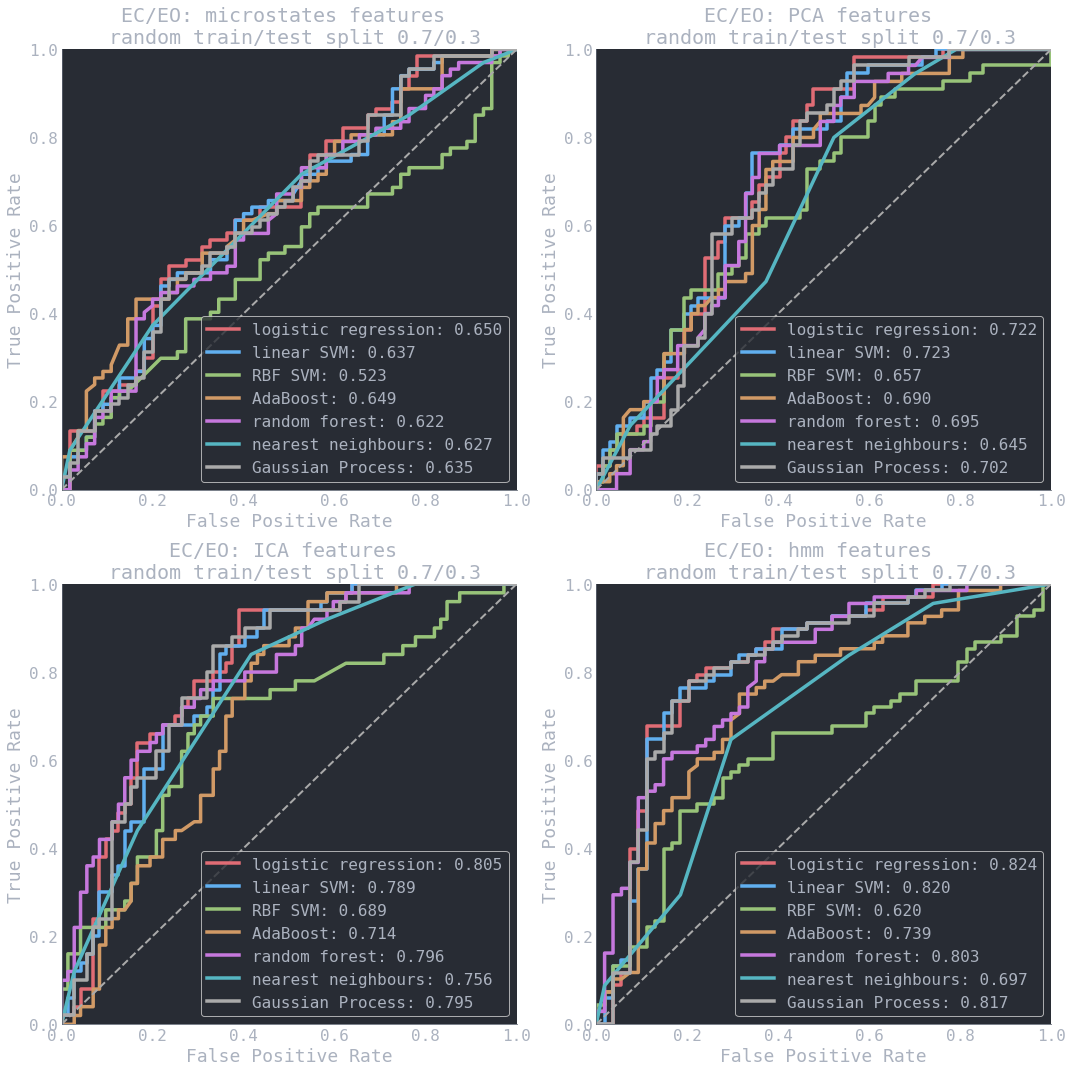

In [5]:
plt.figure(figsize=(15, 15))
for i, (name, df) in enumerate(latent_data.items()):
    x = df.drop("data_type", axis=1).values
    y = df["data_type"].replace({"EC": 0, "EO": 1}).values
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    plot_data = compute_roc_for_multiple(x_train, x_test, y_train, y_test)

    plt.subplot(2, 2, i + 1)
    for i, (clf_name, plt_data) in enumerate(plot_data.items()):
        plt.plot(
            plt_data[0],
            plt_data[1],
            color=f"C{i}",
            label=f"{clf_name}: {plt_data[3]:.3f}",
            linewidth=3.5,
        )
    plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"EC/EO: {name} features \n random train/test split 0.7/0.3")
    plt.legend()
    sns.despine(trim=True)

plt.tight_layout()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.03it/s]


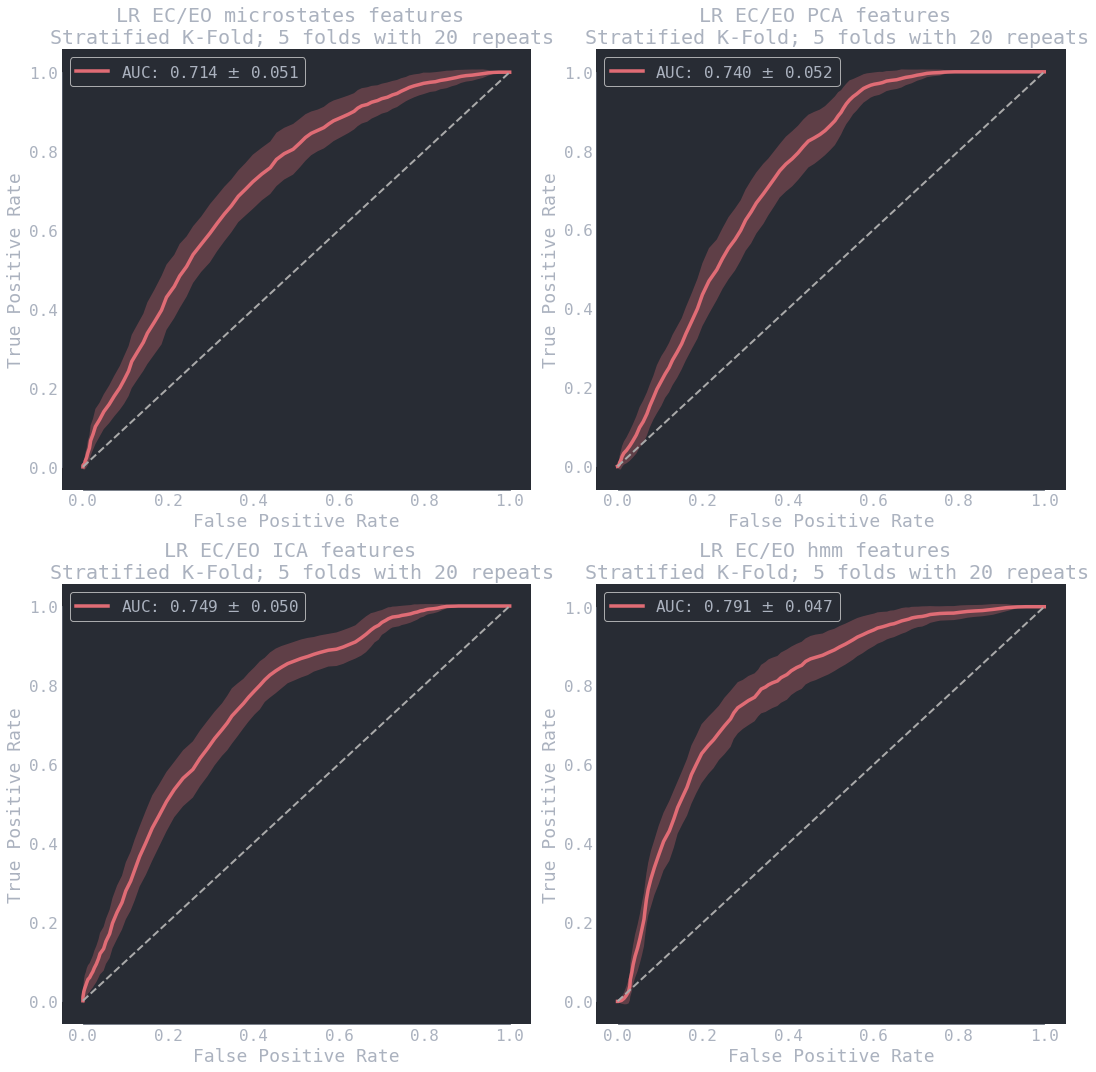

In [6]:
plt.figure(figsize=(15, 15))
for i, (name, df) in enumerate(latent_data.items()):
    x = df.drop("data_type", axis=1).values
    y = df["data_type"].replace({"EC": 0, "EO": 1}).values
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    tpr, fpr, auc, acc, sens, spec = kfold_classifier(
        LogisticRegression(penalty="l2"), x, y
    )
    tpr = np.vstack(tpr)
    fpr = np.vstack(fpr)
    mean_auc = np.mean(auc)
    std_auc = np.std(auc)
    plt.subplot(2, 2, i + 1)
    plt.plot(
        fpr.mean(axis=0),
        tpr.mean(axis=0),
        label=f"AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}",
        linewidth=3.5,
    )
    plt.fill_between(
        fpr.mean(axis=0),
        tpr.mean(axis=0) - tpr.std(axis=0),
        tpr.mean(axis=0) + tpr.std(axis=0),
        alpha=0.3,
    )
    plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(
        f"LR EC/EO {name} features \n Stratified K-Fold; {N_FOLDS} folds with {N_REPEATS} repeats"
    )
    plt.legend()
    sns.despine(trim=True)

plt.tight_layout()

  3%|███▍                                                                                                             | 3/100 [00:02<01:33,  1.04it/s]/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
  5%|█████▋                                                                                                           | 5/100 [00:03<00:58,  1.62it/s]/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
  9%|██████████▏                

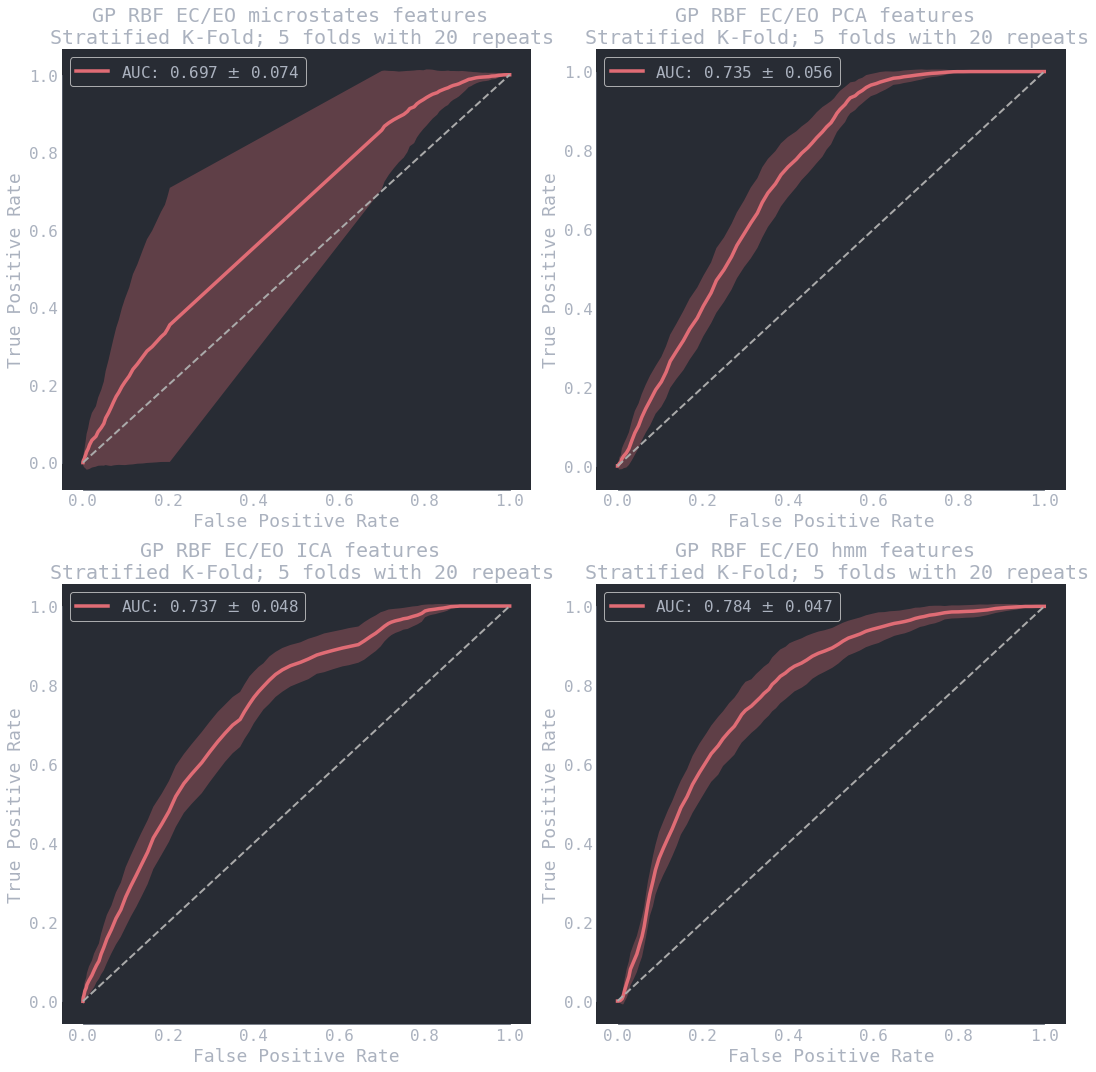

In [7]:
plt.figure(figsize=(15, 15))
for i, (name, df) in enumerate(latent_data.items()):
    x = df.drop("data_type", axis=1).values
    y = df["data_type"].replace({"EC": 0, "EO": 1}).values
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    tpr, fpr, auc, acc, sens, spec = kfold_classifier(
        GaussianProcessClassifier(1.0 * RBF(1.0)), x, y
    )
    tpr = np.vstack(tpr)
    fpr = np.vstack(fpr)
    mean_auc = np.mean(auc)
    std_auc = np.std(auc)
    plt.subplot(2, 2, i + 1)
    plt.plot(
        fpr.mean(axis=0),
        tpr.mean(axis=0),
        label=f"AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}",
        linewidth=3.5,
    )
    plt.fill_between(
        fpr.mean(axis=0),
        tpr.mean(axis=0) - tpr.std(axis=0),
        tpr.mean(axis=0) + tpr.std(axis=0),
        alpha=0.3,
    )
    plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(
        f"GP RBF EC/EO {name} features \n Stratified K-Fold; {N_FOLDS} folds with {N_REPEATS} repeats"
    )
    plt.legend()
    sns.despine(trim=True)

plt.tight_layout()